<h3>Installing the required libraries </h3>

In [7]:
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
from pydub import AudioSegment

<h3>Visualising the waveform of one of the audio files</h3>

Text(0, 0.5, 'Amplitude')

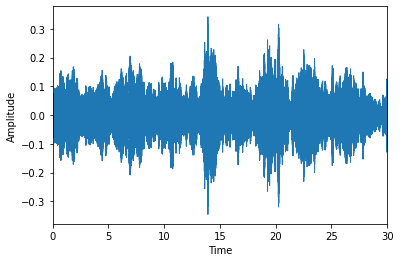

In [17]:
#visualising the waveform of a file
file = 'D:\\Music_Genre_Classifier\\genres\\classical\\classical.00000.wav'
signal, sr = librosa.load(file,sr=22050) #sr*T = 22050*30
librosa.display.waveplot(signal,sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")

<h3>Short time fourier transform to obtain the spectrogram</h3>

In [18]:
#short time fourier transform

num_samples = 2048
hop_length = 512

stft = librosa.core.stft(signal,hop_length = hop_length, n_fft = num_samples)

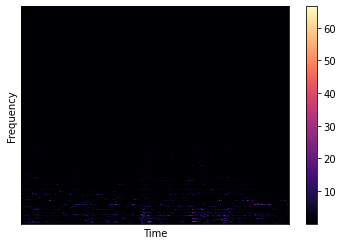

In [19]:
#obtaining the spectrogram
spectrogram = np.abs(stft)
librosa.display.specshow(spectrogram,sr = sr,hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

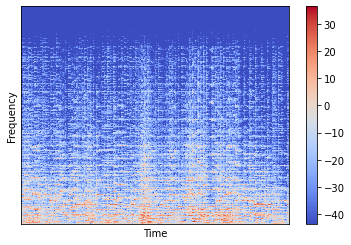

In [20]:
#most frequencies here have very low amplitude
#hence we apply logarithm to increase the amplitude
log_spectrogram = librosa.amplitude_to_db(spectrogram)
librosa.display.specshow(log_spectrogram,sr = sr,hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

<h3>MFCC of the .wav file </h3>

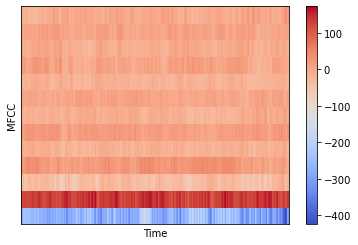

In [21]:
#extracting the MFCC
MFCC = librosa.feature.mfcc(signal,n_fft = num_samples, hop_length=hop_length, n_mfcc= 13)
librosa.display.specshow(MFCC,sr = sr,hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

<h3> Creating empty directories to store the split audio and the spectrograms </h3>

In [2]:
#making empty directories for each genre
os.makedirs('Spectrograms')
os.makedirs('split_audio')

genres = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

for g in genres:
    path_spect = os.path.join('./Spectrograms',f'{g}')
    path_aud =os.path.join('./split_audio',f'{g}')
    os.makedirs(path_spect)
    os.makedirs(path_aud)

<h3> Splitting the 30 second audio file to obtain more data </h3>

In [5]:
i = 0
for g in genres:
    j=0
    #print(f"{g}")
    for filename in os.listdir(os.path.join('D:\\Music_Genre_Classifier\\genres',f"{g}")):
        song  =  os.path.join(f'D:\\Music_Genre_Classifier\\genres\\{g}',f'{filename}')
        #print(song)
        if song == 'D:\\Music_Genre_Classifier\\genres\\jazz\\jazz.00054.wav':
            continue
        j = j+1
        for w in range(0,10):
            i = i+1
            #print(i)
            t1 = 3*(w)*1000
            t2 = 3*(w+1)*1000
            newAudio = AudioSegment.from_wav(song)
            new = newAudio[t1:t2]
            new.export(f'split_audio\\{g}\\{g+str(j)+str(w)}.wav', format="wav")

<h3> Obtaining the spectrograms </h3>

In [18]:
Fs = 22100. #sampling rate
for g in genres:
    j=0
    print(g)
    for filename in os.listdir(os.path.join('D:\\Music_Genre_Classifier\\split_audio',f'{g}')):
        song = os.path.join(f'D:\\Music_Genre_Classifier\\split_audio\\{g}',f'{filename}')
        #print(song)
        y,sr = librosa.load(song, mono=True)
        #print(type(y))
        plt.specgram(y,NFFT=2048, noverlap=128, sides='default', cmap = 'inferno',mode='default', scale='dB',Fs = int(Fs))
        plt.axis('off')
        plt.savefig(f'Spectrograms\\{g}\\{g+str(j)}.png')
        plt.clf()
        j=j+1

blues
classical
country
disco
hiphop


C:\Users\deepu\AppData\Roaming\Python\Python38\site-packages\matplotlib\axes\_axes.py:7581: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


jazz
metal
pop
reggae
rock


<Figure size 432x288 with 0 Axes>

In [19]:
from PIL import Image
img  = Image.open('Spectrograms\\classical\\classical64.png')
width, height = img.size
print(width,'  ',height)

432    288


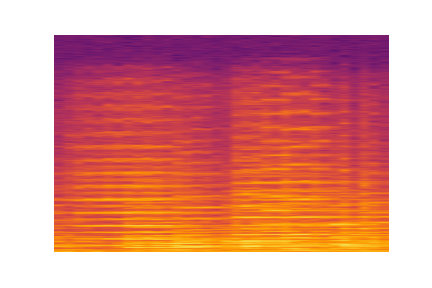

In [20]:
img

<h3> Splitting the data into training and validation data </h3>

In [21]:
import splitfolders
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio('Spectrograms', output="data", seed=1728, ratio=(.8, .2)) # default values

Copying files: 9990 files [01:47, 92.76 files/s] 
